In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import os

In [ ]:
!unzip -q /content/training_solutions_rev1.zip

replace training_solutions_rev1.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
df = pd.read_csv('/content/training_solutions_rev1.csv')

In [ ]:
df_train, df_test = train_test_split(df[:40000], test_size=.2)
df_train.shape, df_test.shape

((32000, 38), (8000, 38))

In [ ]:
df_train.head(10)

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
17036,350882,0.726086,0.241174,0.032740,0.000000,0.241174,0.000000,0.241174,0.000000,0.241174,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
22521,429293,0.794000,0.088000,0.118000,0.000000,0.088000,0.000000,0.088000,0.000000,0.088000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
14755,318505,0.342590,0.622308,0.035103,0.000000,0.622308,0.000000,0.622308,0.274655,0.347653,...,0.000000,0.274655,0.000000,0.0,0.000000,0.031466,0.0,0.0,0.243189,0.000000
5569,182612,0.287802,0.712198,0.000000,0.000000,0.712198,0.155029,0.557169,0.171429,0.540769,...,0.000000,0.000000,0.171429,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.171429
26252,483706,0.327031,0.155775,0.517194,0.000000,0.155775,0.000000,0.155775,0.000000,0.155775,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
16566,344631,0.046078,0.953922,0.000000,0.190784,0.763138,0.148137,0.615000,0.728856,0.034282,...,0.063531,0.182214,0.546642,0.0,0.072886,0.364428,0.0,0.0,0.000000,0.291542
14165,309956,0.176333,0.805469,0.018198,0.547105,0.258364,0.000000,0.258364,0.080779,0.177585,...,0.547105,0.000000,0.080779,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.080779
8060,218334,0.658292,0.297535,0.044173,0.000000,0.297535,0.000000,0.297535,0.073265,0.224270,...,0.000000,0.000000,0.073265,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.073265
3469,152112,0.111100,0.888900,0.000000,0.858837,0.030063,0.000000,0.030063,0.000000,0.030063,...,0.090268,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
20831,404135,0.944801,0.028541,0.026658,0.000000,0.028541,0.000000,0.028541,0.000000,0.028541,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [ ]:
!unzip -q /content/images_training_rev1.zip

In [ ]:
#!unzip -q /content/images_test_rev1.zip

In [ ]:
trainPath = '/content/images_training_rev1'
#testPath = '/content/images_test_rev1'

In [ ]:
import random
def plot_random_galaxy(path, sample=5):
    random_image = random.sample(os.listdir(path), sample)

    plt.figure(figsize=(16,5))
    for i in range(sample):
        plt.subplot(1,sample,i+1)

        # PyTorch version of image reading and processing
        img_path = os.path.join(path, random_image[i])
        img = Image.open(img_path)  # Using Pillow to open image

        # Convert PIL Image to numpy array
        img_array = np.array(img)

        plt.imshow(img_array)
        plt.title(f'Class: {random_image[i]}\nShape: {img_array.shape}')
        plt.axis(False)

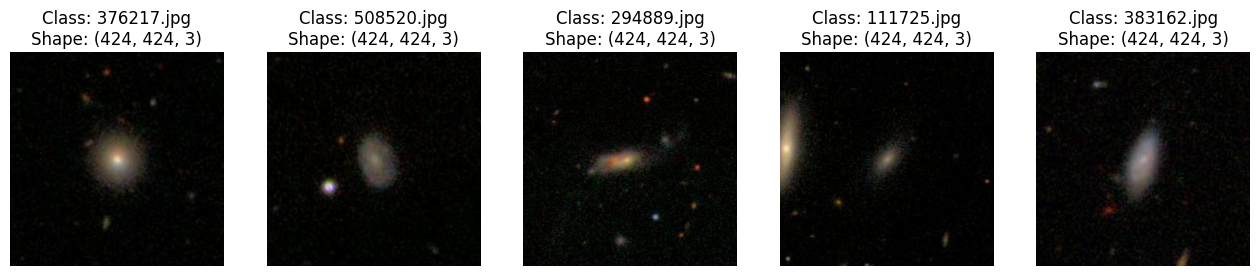

In [ ]:
plot_random_galaxy(trainPath)

In [ ]:
import torch
from skimage.transform import resize
from tqdm import tqdm
import matplotlib.pyplot as plt

ORIG_SHAPE = (424,424)
CROP_SIZE = (256,256)
IMG_SHAPE = (64,64)

def get_image(path, x1, y1, shape, crop_size):
    x = plt.imread(path)
    x = x[x1:x1+crop_size[0], y1:y1+crop_size[1]]
    x = resize(x, shape)
    x = x/255.
    # Convert to PyTorch tensor and add channel dimension if needed
    x = torch.from_numpy(x).float()
    # If grayscale, add channel dimension
    if x.ndim == 2:
        x = x.unsqueeze(0)
    # If RGB, transpose to ensure channel-first format
    elif x.ndim == 3 and x.shape[2] in [3, 4]:
        x = x.permute(2, 0, 1)
    return x

def get_all_images(dataframe, shape=IMG_SHAPE, crop_size=CROP_SIZE):
    x1 = (ORIG_SHAPE[0]-CROP_SIZE[0])//2
    y1 = (ORIG_SHAPE[1]-CROP_SIZE[1])//2

    sel = dataframe.values
    ids = sel[:,0].astype(int).astype(str)
    y_batch = sel[:,1:]

    x_batch = []
    for i in tqdm(ids):
        x = get_image('/content/images_training_rev1/'+i+'.jpg', x1,y1, shape=shape, crop_size=crop_size)
        x_batch.append(x)

    # Convert list of tensors to a single tensor
    x_batch = torch.stack(x_batch)

    # Convert labels to tensor if needed
    y_batch = torch.tensor(y_batch).float()

    return x_batch, y_batch

In [ ]:
X_train, y_train = get_all_images(df_train)
X_test, y_test = get_all_images(df_test)

100%|██████████| 8000/8000 [01:21<00:00, 98.59it/s] 


In [ ]:
X_train.shape

torch.Size([49262, 3, 64, 64])

In [ ]:
X_train[0]

tensor([[[1.7506e-04, 1.2869e-04, 1.0601e-04,  ..., 9.6191e-05,
          1.5285e-04, 1.3218e-04],
         [1.1109e-04, 1.0128e-04, 1.1181e-04,  ..., 1.0205e-04,
          1.4057e-04, 9.8751e-05],
         [8.9767e-05, 9.7521e-05, 1.0943e-04,  ..., 1.2136e-04,
          1.2195e-04, 6.5251e-05],
         ...,
         [7.8166e-05, 1.0156e-04, 7.9715e-05,  ..., 3.9744e-05,
          9.5262e-05, 7.1623e-05],
         [1.3918e-04, 1.4005e-04, 1.1509e-04,  ..., 5.8820e-05,
          8.4403e-05, 4.8134e-05],
         [1.4442e-04, 1.3830e-04, 1.5213e-04,  ..., 1.4630e-04,
          2.0091e-04, 1.9730e-04]],

        [[1.7506e-04, 1.2869e-04, 1.0601e-04,  ..., 9.6191e-05,
          1.5285e-04, 1.3218e-04],
         [1.1109e-04, 1.0128e-04, 1.1181e-04,  ..., 1.0205e-04,
          1.4057e-04, 9.8751e-05],
         [8.9767e-05, 9.7521e-05, 1.0943e-04,  ..., 1.2136e-04,
          1.2195e-04, 6.5251e-05],
         ...,
         [7.0404e-05, 9.3801e-05, 7.2759e-05,  ..., 9.3085e-05,
          1.816

In [ ]:
y_train.shape

torch.Size([49262, 37])

In [ ]:
#there are 49262 images and there are 37 different labels
y_train[0]

tensor([0.4783, 0.5217, 0.0000, 0.0138, 0.5079, 0.3227, 0.1852, 0.1956, 0.3123,
        0.0000, 0.3931, 0.1148, 0.0000, 0.0000, 1.0000, 0.0192, 0.4591, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0138, 0.0000,
        0.0000, 0.0000, 0.1956, 0.0000, 0.0000, 0.1956, 0.0000, 0.0000, 0.0000,
        0.0000])

In [ ]:
#now we will build the model for classification
class Galaxy_Classifier(nn.Module):
  def __init__(self,
               input_shape: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=512, kernel_size=3, padding=1),
        nn.Conv2d(in_channels=512,
                  out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, padding=1),  # Make sure to match input channels from previous layer
        nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
        # Uncomment for BatchNorm if needed
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        # Uncomment if you want to add BatchNorm
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.AdaptiveMaxPool2d(1)
    )
    self.classifier = nn.Sequential(
        nn.Dropout(0.25),
        nn.Linear(128, 128),
        nn.ReLU(),

        #nn.Dropout(0.25),
        #nn.Linear(128, 128),
        #nn.ReLU(),

        nn.Dropout(0.25),
        nn.Linear(128, 128),
        nn.ReLU(),

        nn.Dropout(0.25),
        nn.Linear(in_features=128, out_features=37),
        nn.Sigmoid()

    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.conv_block_3(x)
    #print(x.shape)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)

    #print(x.shape)
    return x

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
model_1 = Galaxy_Classifier(input_shape=3, output_shape=37).to(device)

In [ ]:
model_1

Galaxy_Classifier(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, moment

In [ ]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adamax(params=model_1.parameters(),
                            lr=0.001)

In [ ]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
from torch.utils.data import DataLoader
#setup the batch size hyperparameter
BATCH_SIZE = 128
#turn datasets into iterables(batches)
train_dataloader = DataLoader(
    dataset= list(zip(X_train,y_train)),
    batch_size=BATCH_SIZE,
    shuffle=True

)

test_dataloader = DataLoader(
    dataset= list(zip(X_test,y_test)),
    batch_size=BATCH_SIZE,
    shuffle=False
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x79b258914490>,
 <torch.utils.data.dataloader.DataLoader at 0x79b25ae110c0>)

In [ ]:
#creating a function to time our experiments
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  total_time = end- start
  print(f'Train time on {device}: {total_time:.3f} seconds')
  return total_time


def multi_label_accuracy(predictions, labels, threshold=0.5):
    """
    Calculate accuracy for multi-label classification.

    Args:
    - predictions: torch tensor of predicted probabilities (shape: [37])
    - labels: torch tensor of true labels (shape: [37])
    - threshold: probability threshold for determining positive class

    Returns:
    - Accuracy as a float
    """
    # Convert predictions and labels to binary using threshold
    binary_predictions = (predictions >= threshold).float()
    binary_labels = (labels >= threshold).float()

    # Calculate true positives, true negatives, false positives, false negatives
    true_positives = torch.sum((binary_predictions == 1) & (binary_labels == 1)).float()
    true_negatives = torch.sum((binary_predictions == 0) & (binary_labels == 0)).float()
    false_positives = torch.sum((binary_predictions == 1) & (binary_labels == 0)).float()
    false_negatives = torch.sum((binary_predictions == 0) & (binary_labels == 1)).float()

    # Calculate accuracy
    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

    return accuracy.item()


In [ ]:
from tqdm.auto import tqdm

#set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 100

for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch}\n--------')
  ###training
  train_loss = 0 #coz we are evaluating the model batchwise so we need a variable for overall loss
  for batch, (x, y) in enumerate(train_dataloader):
    model_1.train()
    #x, y = x.to(device), y.to(device)
    y_pred = model_1(x)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #if batch % 400 == 0:
     #print(f'looked at {batch * len(x)}/{len(train_dataloader.dataset)} samples')

  train_loss /= len(train_dataloader)

  test_loss, test_acc = 0,0
  model_1.eval()
  with torch.inference_mode():
    for x_test, y_test in test_dataloader:
      #x_test, y_test = x_test.to(device), y_test.to(device)
      test_pred = model_1(x_test)
      test_loss += loss_fn(test_pred, y_test)
      test_acc += multi_label_accuracy(test_pred, y_test)
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  if epoch%10 == 0:
    print(f'Train loss: {train_loss:.5f}, test loss: {test_loss:.5f}, test acc: {test_acc:.5f}')
  print(f'Train loss: {train_loss:.5f}, test loss: {test_loss:.5f}, test acc: {test_acc:.5f}')

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                             end=train_time_end_on_cpu,
                                             device=str(next(model_1.parameters()).device))

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
--------
looked at 0/49262 samples


In [ ]:
from tqdm.auto import tqdm

#set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_gpu = timer()

epochs = 100

for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch}\n--------')
  ###training
  train_loss = 0 #coz we are evaluating the model batchwise so we need a variable for overall loss
  for batch, (x, y) in enumerate(train_dataloader):
    model_1.train()
    #x, y = x.to(device), y.to(device)
    y_pred = model_1(x)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch % 50 == 0:
      print(f'looked at {batch * len(x)}/{len(train_dataloader.dataset)} samples')

  train_loss /= len(train_dataloader)

  test_loss, test_acc = 0,0
  model_1.eval()
  with torch.inference_mode():
    for x_test, y_test in test_dataloader:
      #x_test, y_test = x_test.to(device), y_test.to(device)
      test_pred = model_1(x_test)
      test_loss += loss_fn(test_pred, y_test)
      test_acc += multi_label_accuracy(test_pred, y_test)
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f'Train loss: {train_loss:.5f}, test loss: {test_loss:.5f}, test acc: {test_acc:.5f}')

train_time_end_on_gpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_gpu,
                                             end=train_time_end_on_gpu,
                                             device=str(next(model_1.parameters()).device))


In [1]:
from IPython.display import clear_output
clear_output(wait=True)